In [4]:
# Imports
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
%run toolkits/ml-toolkits/plot_confusion_matrix.py

channel list ['x_sensor_acc', 'x_watch_acc', 'x_watch_gyr', 'y_sensor_acc', 'y_watch_acc', 'y_watch_gyr', 'z_sensor_acc', 'z_watch_acc', 'z_watch_gyr']
training model
load model and test
INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt


INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt


Test accuracy: 0.753709
(674, 128, 9)
(674, 18)
(674,)
(0.0, 0.0, 0.0, None)
Accuracy: 0.753709198813
F1 score: 0.756020706789
Recall: 0.765067888856
Precision: 0.777909822311

 clasification report:
             precision    recall  f1-score   support

          0    0.69231   0.94737   0.80000        19
          1    1.00000   0.95000   0.97436        20
          2    1.00000   1.00000   1.00000        20
          3    0.89474   0.89474   0.89474        19
          4    0.67308   0.85366   0.75269        41
          5    0.50000   0.89189   0.64078        37
          6    0.54902   0.45161   0.49558        62
          7    0.96078   0.89091   0.92453        55
          8    0.80000   0.95238   0.86957        21
          9    1.00000   0.68293   0.81159        41
         10    0.84615   0.46809   0.60274        47
         11    0.96721   0.79730   0.87407        74
         12    0.95745   0.95745   0.95745        47
         13    0.97727   0.87755   0.92473        49
    

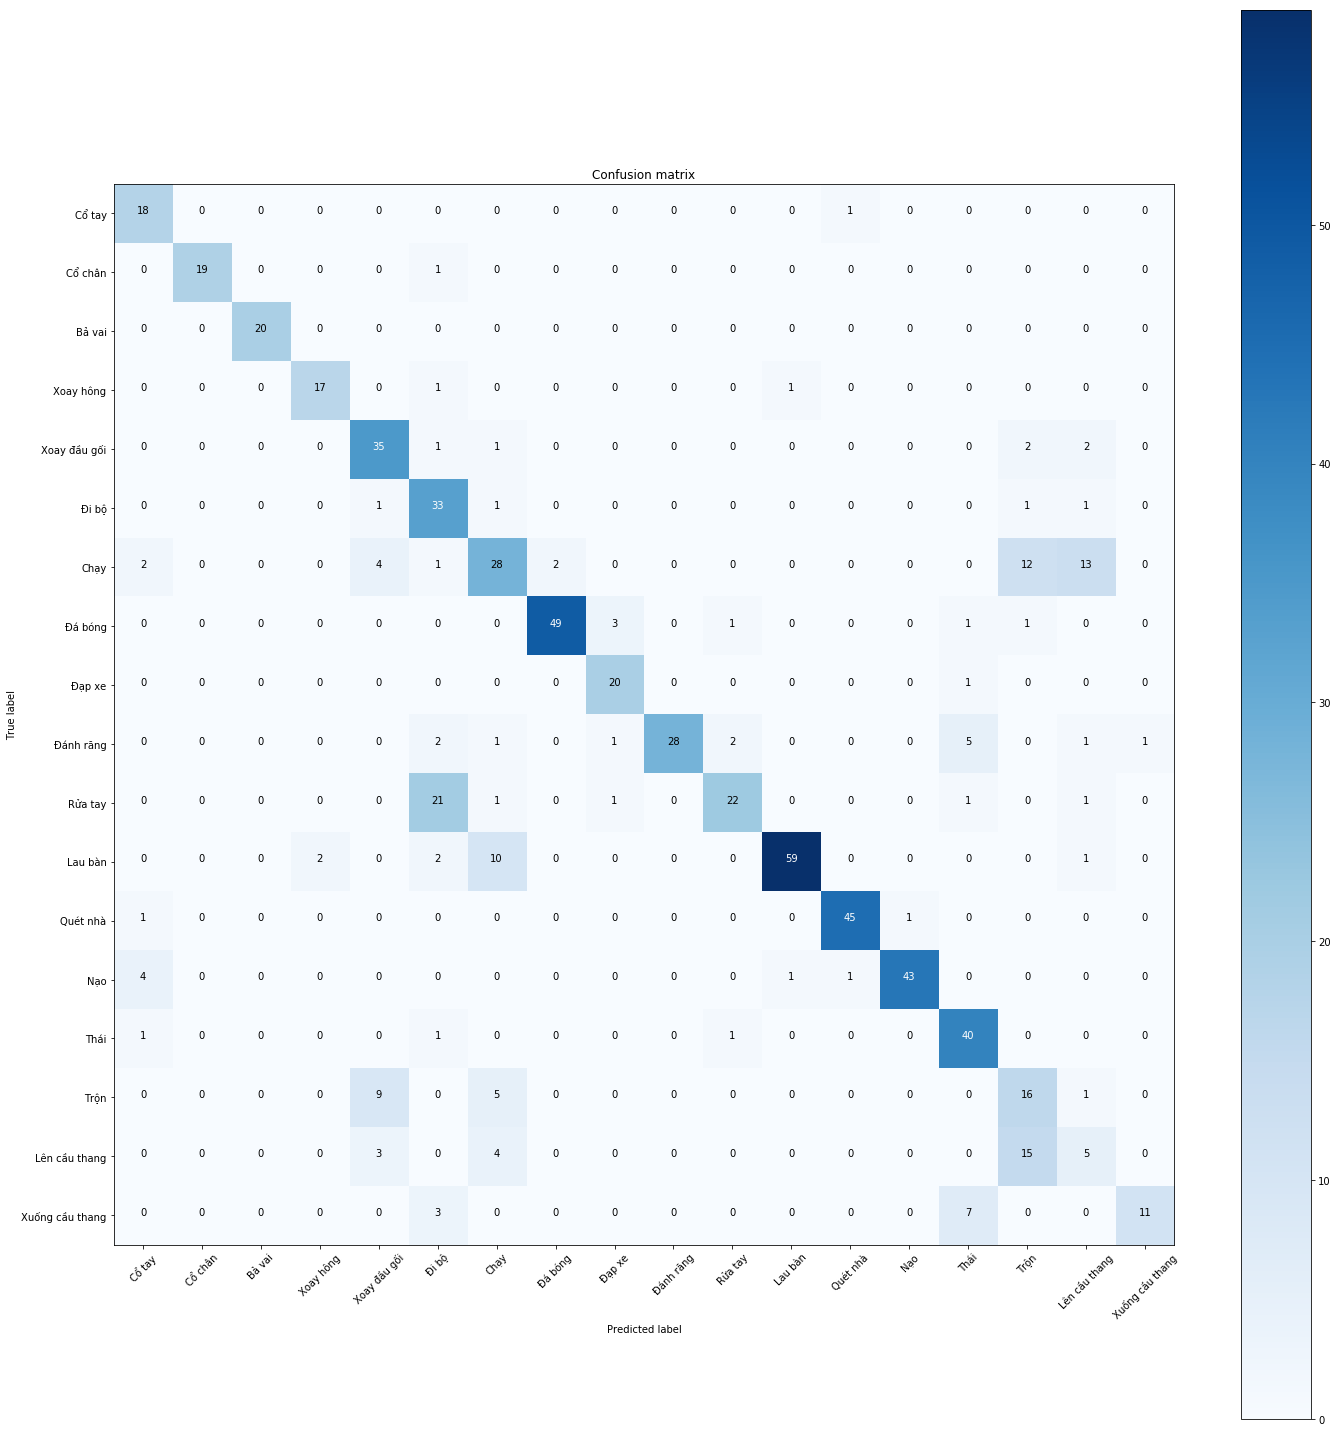

In [14]:

# coding: utf-8

# # HAR CNN training 

# In[292]:
# HAR classification 
# Author: Burak Himmetoglu
# 8/15/2017

import pandas as pd 
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score,     recall_score, confusion_matrix, classification_report,     accuracy_score, f1_score

WINDOWN_SIZE = 128
CHANNEL_LIST = ["x_sensor_acc","y_sensor_acc","z_sensor_acc","x_watch_acc","y_watch_gyr","z_watch_acc","x_watch_gyr","y_watch_acc","z_watch_gyr"]
NUM_CHANNEL = len(CHANNEL_LIST)

class_label = ["wrist","ankle","shoulder","haunch","knee","walking","running","kicking","cycling","brushing","washing_hand","sweep_floor","peel","slice","mixing","upstair","downstair"]
class_label=["wrist","ankle","shoulder","haunch","knee","walking","running","kicking","cycling","brushing","washing_hand","wipe","sweep_floor","peel","slice","mixing","upstair","downstair"]

class_label_vn = [u"Cổ tay",u"Cổ chân",u"Bả vai",u"Xoay hông",u"Xoay đầu gối",u"Đi bộ",u"Chạy",u"Đá bóng",u"Đạp xe",u"Đánh răng",u"Rửa tay", u"Lau bàn", u"Quét nhà", u"Nạo",u"Thái",u"Trộn",u"Lên cầu thang",u"Xuống cầu thang"]

NUM_CLASS = len(class_label)
class_label_int = {val:str(idx) for idx, val in enumerate(class_label)}


# network hyperparametter
batch_size = 600       # Batch size
seq_len = WINDOWN_SIZE          # Number of steps or window size
learning_rate = 0.0001
epochs = 1000

n_classes = NUM_CLASS
n_channels = NUM_CHANNEL

def read_data(data_path, split = "train"):
    """ Read data """

    # Fixed params
    n_class = NUM_CLASS
    n_steps = WINDOWN_SIZE

    # Paths
    path_ = os.path.join(data_path, split)
    path_signals = os.path.join(path_, "sensor")

    # Read labels and one-hot encode
    label_path = os.path.join(path_, "class.txt")
    labels = pd.read_csv(label_path, header = None)
    
    # Read time-series data
    channel_files = os.listdir(path_signals)
    channel_files.sort()
    n_channels = len(channel_files)
    posix = len(split) + 5

    # Initiate array
    list_of_channels = []
    X = np.zeros((len(labels), n_steps, n_channels))
    i_ch = 0
    for fil_ch in channel_files:
        channel_name = fil_ch[:-4]
        dat_ = pd.read_csv(os.path.join(path_signals,fil_ch), delim_whitespace = True, header = None)
        X[:,:,i_ch] = dat_.as_matrix()

        # Record names
        list_of_channels.append(channel_name)

        # iterate
        i_ch += 1

    # Return 
    return X, labels[0].values, list_of_channels

def standardize(train, test):
    """ Standardize data """

    # Standardize train and test
    X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
    X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]

    return X_train, X_test

def one_hot(labels, n_class = NUM_CLASS):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

def get_batches(X, y, batch_size = 100):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]
    
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')


with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')

    # (batch, 64, 18) --> (batch, 32, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')

    # (batch, 32, 36) --> (batch, 16, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')

    # (batch, 16, 72) --> (batch, 8, 144)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')


# Now, flatten and pass to the classifier

# In[303]:


with graph.as_default():
    flat = tf.reshape(max_pool_4, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)

    logits = tf.layers.dense(flat, n_classes)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)

    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    prediction=tf.argmax(logits,1)
    
with graph.as_default():
    saver = tf.train.Saver()
        
def train_model(graph, X_tr, y_tr):    
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        iteration = 1

        for e in range(epochs):

            for x,y in get_batches(X_tr, y_tr, batch_size):

                feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}

                # Loss
                loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
#                 train_acc.append(acc)
#                 train_loss.append(loss)
                iteration += 1

        saver.save(sess,"checkpoints-cnn/har.ckpt")


def test_model(graph, X_test, y_test):
    global accuracy
    test_acc = []
    with tf.Session(graph=graph) as sess:
        # Restore
        saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
        y_pred = []
        y_true = []
        feed = {inputs_: X_test,
                labels_: y_test,
                keep_prob_: 1}
        batch_acc, batch_y_pred = sess.run([accuracy, prediction], feed_dict=feed)
        y_pred.extend(batch_y_pred)
        y_true.extend(np.where(r==1)[0][0] for r in y_test )

        test_acc.append(batch_acc)
        print("Test accuracy: {:.6f}".format(np.mean(test_acc)))
        print X_test.shape
        print y_test.shape
        print batch_y_pred.shape
        sk_class_labels = [i for i in range(NUM_CLASS)]
        accuracy1 = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        print precision_recall_fscore_support(y_true, y_pred, average='macro', labels=class_label)
        print 'Accuracy:', accuracy_score(y_true, y_pred)
        print 'F1 score:', f1
        print 'Recall:', recall
        print 'Precision:', precision
        print '\n clasification report:\n', classification_report(y_true,y_pred,digits=5)
        cf_matrix = confusion_matrix(y_true, y_pred)
#         fig, ax = plt.subplots() 
#         fig_size = plt.rcParams["figure.figsize"]
#         fig_size[0] = 20
#         fig_size[1] = 10
#         plt.rcParams["figure.figsize"] = fig_size
        plt.figure()
        plot_confusion_matrix(cf_matrix, class_label_vn, title='Confusion matrix')
        return accuracy1, precision, recall, f1
        
def getPredicted(graph, X_test):
    global accuracy
    test_acc = []
    with graph.as_default():
        prediction=tf.argmax(logits,1)
    with tf.Session(graph=graph) as sess:
        # Restore
        saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
        y_pred = []
        y_true = []
        feed = {inputs_: X_test,
                keep_prob_: 1}
        batch_y_pred = sess.run([prediction], feed_dict=feed)
    return batch_y_pred
def train():
    global graph
    rootDatasetDir = "./datasets/PTIT/normalized"
    X_train, labels_train, list_ch_train = read_data(data_path="./datasets/PTIT/normalized", split="train") # train
    X_test, labels_test, list_ch_test = read_data(data_path=rootDatasetDir, split="test") # test
    assert list_ch_train == list_ch_test, "Mistmatch in channels!"
    
    print "channel list", list_ch_train

#     X_train, X_test = standardize(X_train, X_test)

    X_tr=X_train
    lab_tr=labels_train



    y_tr = one_hot(lab_tr)
    y_test = one_hot(labels_test)


    validation_acc = []
    validation_loss = []

    train_acc = []
    train_loss = []
    
#     graph = build_net()
    print "training model"
#     train_model(graph, X_tr, y_tr)
    print "load model and test"
    test_model(graph, X_test, y_test)
#    print getPredicted(graph, X_test)
train()